# 83. 소개

## 1. SO 전략 이해 및 코드 작성, 최적화
## 2. 거래/트랜젝션 비용의 중요성
## 3. OOP 프레임워크 작성

# 84. 데이터 가져오기

In [1]:
!pip install pyupbit

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyupbit
plt.style.use("seaborn")

In [3]:
df = pyupbit.get_ohlcv("KRW-BTC", interval="day", count=5*365)
df

,open,high,low,close,volume,value
2017-09-25 09:00:00+09:00,4201000.0,4333000.0,4175000.0,4322000.0,132.484755,5.602146e+08
2017-09-26 09:00:00+09:00,4317000.0,4418000.0,4311000.0,4321000.0,22.788340,9.950724e+07
2017-09-27 09:00:00+09:00,4322000.0,4677000.0,4318000.0,4657000.0,32.269662,1.448276e+08
2017-09-28 09:00:00+09:00,4657000.0,4772000.0,4519000.0,4586000.0,80.588243,3.721860e+08
2017-09-29 09:00:00+09:00,4586000.0,4709000.0,4476000.0,4657000.0,59.352373,2.724558e+08
...,...,...,...,...,...,...
2022-06-02 09:00:00+09:00,37880000.0,38680000.0,37558000.0,38392000.0,2899.345673,1.102368e+11
2022-06-03 09:00:00+09:00,38393000.0,38630000.0,37378000.0,37851000.0,3606.947470,1.372389e+11
2022-06-04 09:00:00+09:00,37852000.0,38100000.0,37666000.0,37916000.0,1401.312285,5.302511e+10
2022-06-05 09:00:00+09:00,37916000.0,38300000.0,37608000.0,37972000.0,1320.221687,4.998600e+10


<AxesSubplot:title={'center':'KRW-BTC'}>

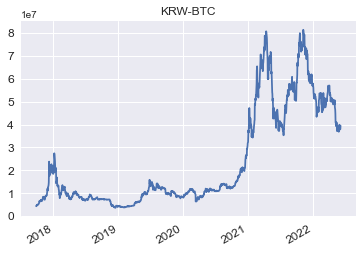

In [4]:
df.close.plot(figsize=(6,4), title = "KRW-BTC", fontsize=12)

In [5]:
df["returns"] = np.log(df.close.div(df.close.shift(1)))

# 85. SO 전략의 정의

## 구성
- 0~100으로 구성된 2개의 선으로 구성
- Fast Stochastic Indicator(%K line)
- Slow Stochastic Indicator(%D line)

## 계산 방법
- %K
<img src="../data/img/stochastic_k.png" width=1000 />

In [6]:
periods = 14

In [7]:
df["roll_low"] = df.low.rolling(periods).min()
df["roll_high"] = df.low.rolling(periods).max()
df.tail()

,open,high,low,close,volume,value,returns,roll_low,roll_high
2022-06-02 09:00:00+09:00,37880000.0,38680000.0,37558000.0,38392000.0,2899.345673,1.102368e+11,0.013426,36394000.0,39300000.0
2022-06-03 09:00:00+09:00,38393000.0,38630000.0,37378000.0,37851000.0,3606.947470,1.372389e+11,-0.014192,36394000.0,39300000.0
2022-06-04 09:00:00+09:00,37852000.0,38100000.0,37666000.0,37916000.0,1401.312285,5.302511e+10,0.001716,36394000.0,39300000.0
2022-06-05 09:00:00+09:00,37916000.0,38300000.0,37608000.0,37972000.0,1320.221687,4.998600e+10,0.001476,36394000.0,39300000.0
2022-06-06 09:00:00+09:00,37974000.0,39678000.0,37966000.0,39471000.0,2993.957462,1.174174e+11,0.038717,36394000.0,39300000.0


<AxesSubplot:>

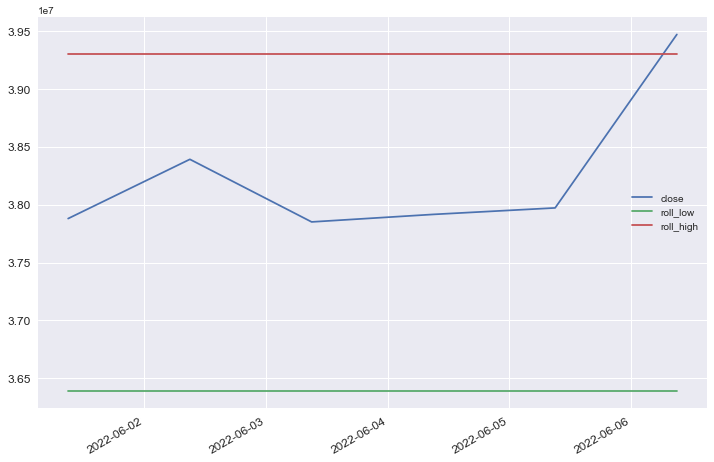

In [8]:
df.loc["2022/06":, ["close", "roll_low", "roll_high"]].plot(figsize=(12,8), fontsize=12)

In [9]:
df["K"] = (df.close - df.roll_low)/(df.roll_high - df.roll_low) * 100

<AxesSubplot:>

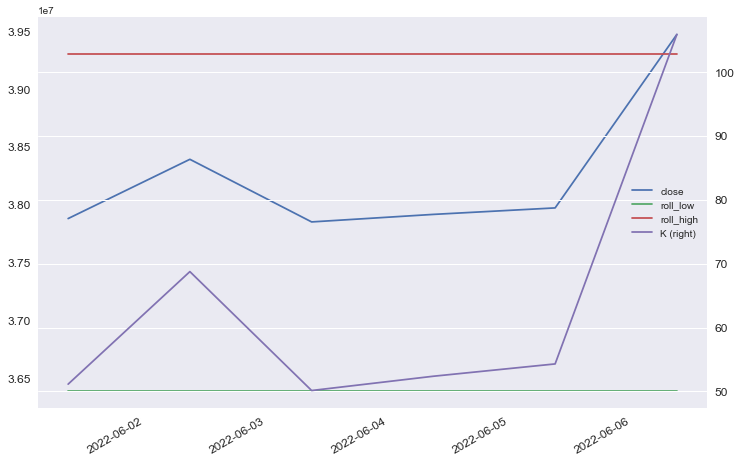

In [10]:
df.loc["2022/06":, ["close", "roll_low", "roll_high", "K"]].plot(figsize=(12,8), fontsize=12, secondary_y="K")

## 계산 방법
- %D
<img src="../data/img/stochastic_d.png" width=1000 />

In [11]:
window = 3

In [12]:
df["D"] = df.K.rolling(window).mean()

<AxesSubplot:>

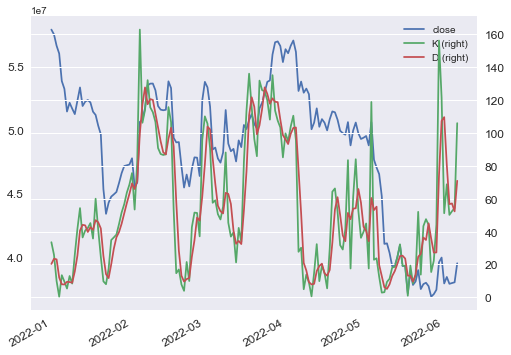

In [13]:
df.loc["2022":, ["close", "K", "D"]].plot(figsize=(8,6), fontsize=12, secondary_y=["K","D"])

In [14]:
df["position"] = np.where(df["K"] > df["D"], 1, -1)

<AxesSubplot:>

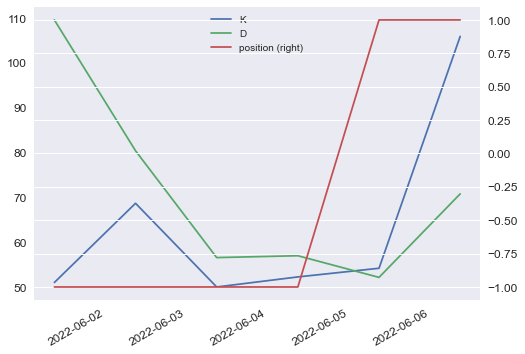

In [15]:
df.loc["2022/06":, ["K", "D", "position"]].plot(figsize=(8,6), fontsize=12, secondary_y="position")

# 86. 백터화 전략 백테스팅

In [16]:
df["strategy"] = df.position.shift(1) * df["returns"]

In [17]:
df.dropna(inplace=True)

In [18]:
df["trades"] = df.position.diff().fillna(0).abs()

In [19]:
df.trades.value_counts()

0.0    1006
2.0     695
Name: trades, dtype: int64

In [20]:
df["creturns"] = df["returns"].cumsum().apply(np.exp)
df["cstrategy"] = df["strategy"].cumsum().apply(np.exp)

<AxesSubplot:>

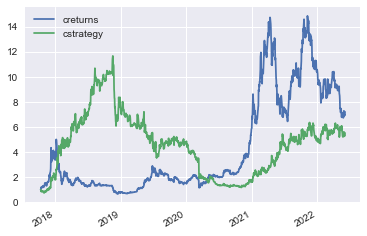

In [21]:
df[["creturns", "cstrategy"]].plot(figsize=(6,4))

# 87. SO 백테스팅 클래스의 실행

In [22]:
import pandas as pd
import numpy as np
import pyupbit
import matplotlib.pyplot as plt
import datetime
import pytz


class CoinInstrument:
    KST = datetime.timezone(datetime.timedelta(hours=9))

    def __init__(self, ticker, to=None, count=200, interval='day', period=0.5):
        self._data = None
        self.ticker = ticker
        self.interval = interval
        self.count = count
        self.to = to
        self.period = period
        self.load_data()
        self._data["log_returns"] = self.log_returns()

    def __repr__(self):
        return "CoinInstrument(ticker={}, to={}, count={}, interval={})".format(self.ticker, self.to,
                                                                                self.count, self.interval)

    # def to_origin(self):
    #     return self._utc_to_kst(self._to)
    #
    # def _kst_to_utc(self, to):
    #     return pd.to_datetime(to).to_pydatetime().replace(tzinfo=CoinInstrument.KST).astimezone(
    #         datetime.timezone.utc).strftime("%Y-%m-%d %H:%M:%S")
    #
    # def _utc_to_kst(self, to):
    #     return pd.to_datetime(to).to_pydatetime().replace(tzinfo=datetime.timezone.utc).astimezone(
    #         CoinInstrument.KST).strftime("%Y-%m-%d %H:%M:%S")

    def load_data(self):
        self._data = pyupbit.get_ohlcv(self.ticker, self.interval, self.count, self.to, self.period)
        # self._data.index = self._data.index.tz_convert(None).tz_localize('Asia/Seoul')

    def symbol(self):
        return self.ticker

    def log_returns(self):
        return np.log(self._data.close / self._data.close.shift(1))

    def plot_prices(self, figsize=(12, 8)):
        self._data.close.plot(figsize=figsize)
        plt.title("Close chart : {}".format(self.ticker), fontsize=15)

    def plot_returns(self, kind="ts", figsize=(12, 8)):
        if kind == "ts":
            self._data.log_returns.plot(figsize=figsize)
            plt.title("Returns : {}".format(self.ticker), fontsize=15)
        elif kind == "hist":
            self._data.log_returns.hist(figsize=figsize, bins=int(np.sqrt(len(self._data))))
            plt.title("Frequency of Returns : {}".format(self.ticker), fontsize=15)

    def so(self, periods, d_window):
        raw = pd.DataFrame(index=self._data.index)
        raw["roll_low"] = self._data.low.rolling(periods).min()
        raw["roll_high"] = self._data.high.rolling(periods).max()
        raw["K"] = (self._data.close - raw.roll_low) / (raw.roll_high - raw.roll_low) * 100
        raw["D"] = raw.K.rolling(d_window).mean()
        return raw.loc[:, ["K", "D"]].copy()

In [23]:
from scipy.optimize import brute
import numpy as np
import pandas as pd

class SOBackTester:
  def __init__(self, symbol, to=None, count=200, interval='day', period=0.5, periods=14,d_window=3):
    self.results = None
    self._data = None
    self.coinInstrument = CoinInstrument(symbol, to, count, interval, period)
    self._periods = periods
    self._d_window = d_window
    self.load_data()

  def __repr__(self):
    return "SOBackTester(ticker={}, to={}, count={}, interval={}, periods={}, d_window={})"\
      .format(self.coinInstrument.ticker, self.coinInstrument.to, self.coinInstrument.count, self.coinInstrument.interval,
              self._periods, self._d_window)

  def load_data(self):
    self._data = self.coinInstrument.so(self._periods, self._d_window)

  def set_parameters(self, periods=None, d_window=None):
    if periods is not None:
      self._periods = periods
    if d_window is not None:
      self._d_window = d_window

    self.load_data()

  def test_strategy(self):
    data = self._data.copy()
    data["returns"] = self.coinInstrument.log_returns()
    data.dropna(inplace=True)
    data["position"] = np.where(data["K"] > data["D"], 1, -1)
    data["strategy"] = data["position"].shift(1) * data["returns"]
    data.dropna(inplace=True)
    data["creturns"] = data["returns"].cumsum().apply(np.exp)
    data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
    self.results = data
    perf = data["cstrategy"].iloc[-1]
    outperf = perf - data["creturns"].iloc[-1]
    return round(perf, 6), round(outperf, 6)

  def plot_returns(self):
    if self.results is None:
      print("No results to plot yet. Run a strategy")
    else:
      title = "{} | SO = {}/{}".format(self.coinInstrument.symbol(), self._periods, self._d_window)
      self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(6,4))

  def update_and_run(self, so=None):
    self.set_parameters(int(so[0]), int(so[1]))
    return -self.test_strategy()[0]

  def optimize_parameters(self, periods_range, d_window_range):
    opt = brute(self.update_and_run, (periods_range, d_window_range), finish=None)
    return opt, -self.update_and_run(opt)

In [24]:
soTester = SOBackTester("KRW-BTC", interval="day", count=5*365)
soTester.optimize_parameters((7,20,1), (2,10))

(array([ 7., 10.]), 250.208124)

In [25]:
soTester.set_parameters(7,10)

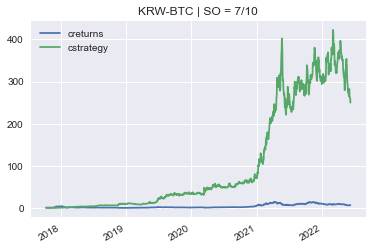

In [26]:
soTester.plot_returns()

# 88. OOP 도전 과제: SO 백테스팅 클래스

# 89. SO 전략의 대안과 해석

In [27]:
from algobot.BackTester import SOHorizonBackTester

In [28]:
tester = SOHorizonBackTester("KRW-BTC", count=365*5, interval="day", periods=14, upper=80, lower=20)

In [30]:
tester.test_strategy()

(2.9e-05, -24.847471)

In [34]:
tester.optimize_parameters((5,15,1), (70,80,1), (20,30,1))

(array([ 5., 79., 21.]), 0.000131)

In [37]:
tester.set_parameters(10, 75, 20)

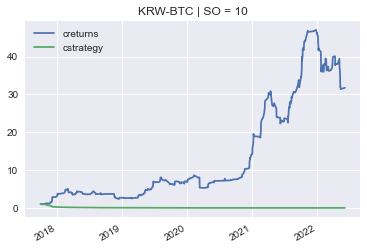

In [38]:
tester.plot_returns()